In [ ]:
!pip install -qU malariagen_data
%pip install -q --no-warn-conflicts petl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.9/775.9 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.9/25.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7

In [ ]:
import allel
import malariagen_data
import itertools
import numpy as np
import re
import plotly.express as px
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
#pd.reset_option('^display.', silent=True)
import numba
from numba import njit
import functools
#import dask
from dask.diagnostics.progress import ProgressBar
#dask.config.set(**{'array.slicing.split_large_chunks': True})
import petl as etl
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.legend import Legend
#import matplotlib_venn as venn
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
#Mounting Google Drive
import os
from google.colab import drive
drive.mount("drive")

# make dir
results_dir = "drive/MyDrive"
os.makedirs(results_dir, exist_ok=True)

Mounted at drive


In [ ]:
ag3 = malariagen_data.Ag3()
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release_master_us_central1/
Data releases available : 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 3.10, 3.11, 3.12, 3.13, 3.14
Results cache           : None
Cohorts analysis        : 20250131
AIM analysis            : 20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 15.0.1
Client location         : Utah, United States (Google Cloud us-west3)
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact support@malariagen.net. For API documentation see 
https://malariagen.github.io/malariagen-data-python/v15.0.1/Ag3.html

In [ ]:
## access to df_samples sets
sets = ["AG1000G-BF-A", "AG1000G-BF-B", "AG1000G-BF-C", "AG1000G-GH", "AG1000G-GN-A", "AG1000G-GN-B", "AG1000G-MW", "AG1000G-TZ"]
df_samples=ag3.sample_metadata(sample_sets=sets)
#df_samples

cohorts, labels = {}, {}
for co, sp, yr in zip(df_samples.country_iso, df_samples.aim_species, df_samples.year):
  country = df_samples.query(f'country_iso=="{co}"').country.unique()[0]
  key = co+"_"+sp+"_"+str(yr)
  cohorts[key] = f'country=="{country}" and aim_species=="{sp}" and year=={yr}'
  if sp in ['gambiae','coluzzii','arabiensis']:
    labels[key] = f'An. {sp} ({co}, {yr})'
  else:
    labels[key] = f'{sp[:3]} ({co}, {yr})'
#cohorts, labels

##cohorts size
cohorts_size, cohorts_size_ = {}, {}
for coh in cohorts.keys():
  cohorts_size[coh] = df_samples.query(f'{cohorts[coh]}').shape[0]

In [ ]:
## genesets
genes = ['AGAP006220', 'AGAP006221','AGAP006224', 'AGAP006225', 'AGAP006226']
genesets = ag3.geneset().query('Parent in @genes')
transcripts = list(genesets.ID.unique())
transcripts

['AGAP006220-RA',
 'AGAP006221-RA',
 'AGAP006224-RA',
 'AGAP006225-RA',
 'AGAP006226-RA']

In [ ]:
## SNP freq in the AGAP006220-RA
freq_AGAP006220 = ag3.snp_allele_frequencies(transcript=transcripts[0], sample_sets=sets,
                                             cohorts=cohorts,drop_invariant=True, effects=True)
freq_AGAP006220.reset_index(inplace=True)
#freq_AGAP006220.drop(columns=['index'])
freq_AGAP006220_df = freq_AGAP006220.query("effect == 'NON_SYNONYMOUS_CODING'")

## SNP freq in the AGAP006221-RA
freq_AGAP006221 = ag3.snp_allele_frequencies(transcript=transcripts[1], sample_sets=sets,
                                             cohorts=cohorts,drop_invariant=True, effects=True)
freq_AGAP006221.reset_index(inplace=True)
#freq_AGAP006221#.drop(columns=['index'])
freq_AGAP006221_df = freq_AGAP006221.query("effect == 'NON_SYNONYMOUS_CODING'")

## SNP freq in the AGAP006224-RA
freq_AGAP006224 = ag3.snp_allele_frequencies(transcript=transcripts[2], sample_sets=sets,
                                             cohorts=cohorts,drop_invariant=True, effects=True)
freq_AGAP006224.reset_index(inplace=True)
#freq_AGAP006224.drop(columns=['index'])
freq_AGAP006224_df = freq_AGAP006224.query("effect == 'NON_SYNONYMOUS_CODING'")

## SNP freq in the AGAP006225-RA
freq_AGAP006225 = ag3.snp_allele_frequencies(transcript=transcripts[3], sample_sets=sets,
                                             cohorts=cohorts,drop_invariant=True, effects=True)
freq_AGAP006225.reset_index(inplace=True)
#freq_AGAP006225.drop(columns=['index'])
freq_AGAP006225_df = freq_AGAP006225.query("effect == 'NON_SYNONYMOUS_CODING'")

## SNP freq in the AGAP006226-RA
freq_AGAP006226 = ag3.snp_allele_frequencies(transcript=transcripts[4], sample_sets=sets,
                                             cohorts=cohorts,drop_invariant=True, effects=True)
freq_AGAP006226.reset_index(inplace=True)
#freq_AGAP006226.drop(columns=['index'])
freq_AGAP006226_df = freq_AGAP006226.query("effect == 'NON_SYNONYMOUS_CODING'")

Load SNP genotypes:   0%|          | 0/44 [00:00<?, ?it/s]

Compute allele frequencies:   0%|          | 0/16 [00:00<?, ?it/s]

Compute SNP effects:   0%|          | 0/2177 [00:00<?, ?it/s]

Load SNP genotypes:   0%|          | 0/44 [00:00<?, ?it/s]

Compute allele frequencies:   0%|          | 0/16 [00:00<?, ?it/s]

Compute SNP effects:   0%|          | 0/2638 [00:00<?, ?it/s]

Load SNP genotypes:   0%|          | 0/44 [00:00<?, ?it/s]

Compute allele frequencies:   0%|          | 0/16 [00:00<?, ?it/s]

Compute SNP effects:   0%|          | 0/2672 [00:00<?, ?it/s]

Load SNP genotypes:   0%|          | 0/44 [00:00<?, ?it/s]

Compute allele frequencies:   0%|          | 0/16 [00:00<?, ?it/s]

Compute SNP effects:   0%|          | 0/2485 [00:00<?, ?it/s]

Load SNP genotypes:   0%|          | 0/44 [00:00<?, ?it/s]

Compute allele frequencies:   0%|          | 0/16 [00:00<?, ?it/s]

Compute SNP effects:   0%|          | 0/2063 [00:00<?, ?it/s]

# Plotting SNP freq

In [ ]:
## number of NS coding SNPs
## number of NS coding SNPs
for i in range(len(transcripts)):
  trans = transcripts[i].split('-')[0]
  df = f'freq_{trans}_df'
  print(globals()[df].shape[0], f' non-synonymous coding SNPs in the {trans} gene.')

557  non-synonymous coding SNPs in the AGAP006220 gene.
676  non-synonymous coding SNPs in the AGAP006221 gene.
1416  non-synonymous coding SNPs in the AGAP006224 gene.
953  non-synonymous coding SNPs in the AGAP006225 gene.
780  non-synonymous coding SNPs in the AGAP006226 gene.


# AGAP006220

In [ ]:
select_freq1 = freq_AGAP006220_df.query("max_af > 0.4")
color_1 = sns.light_palette("darkslategray",n_colors=100)
color_2 = sns.color_palette("ch:s=16,rot=0.05,dark=0.18,light=0.99", as_cmap=True)

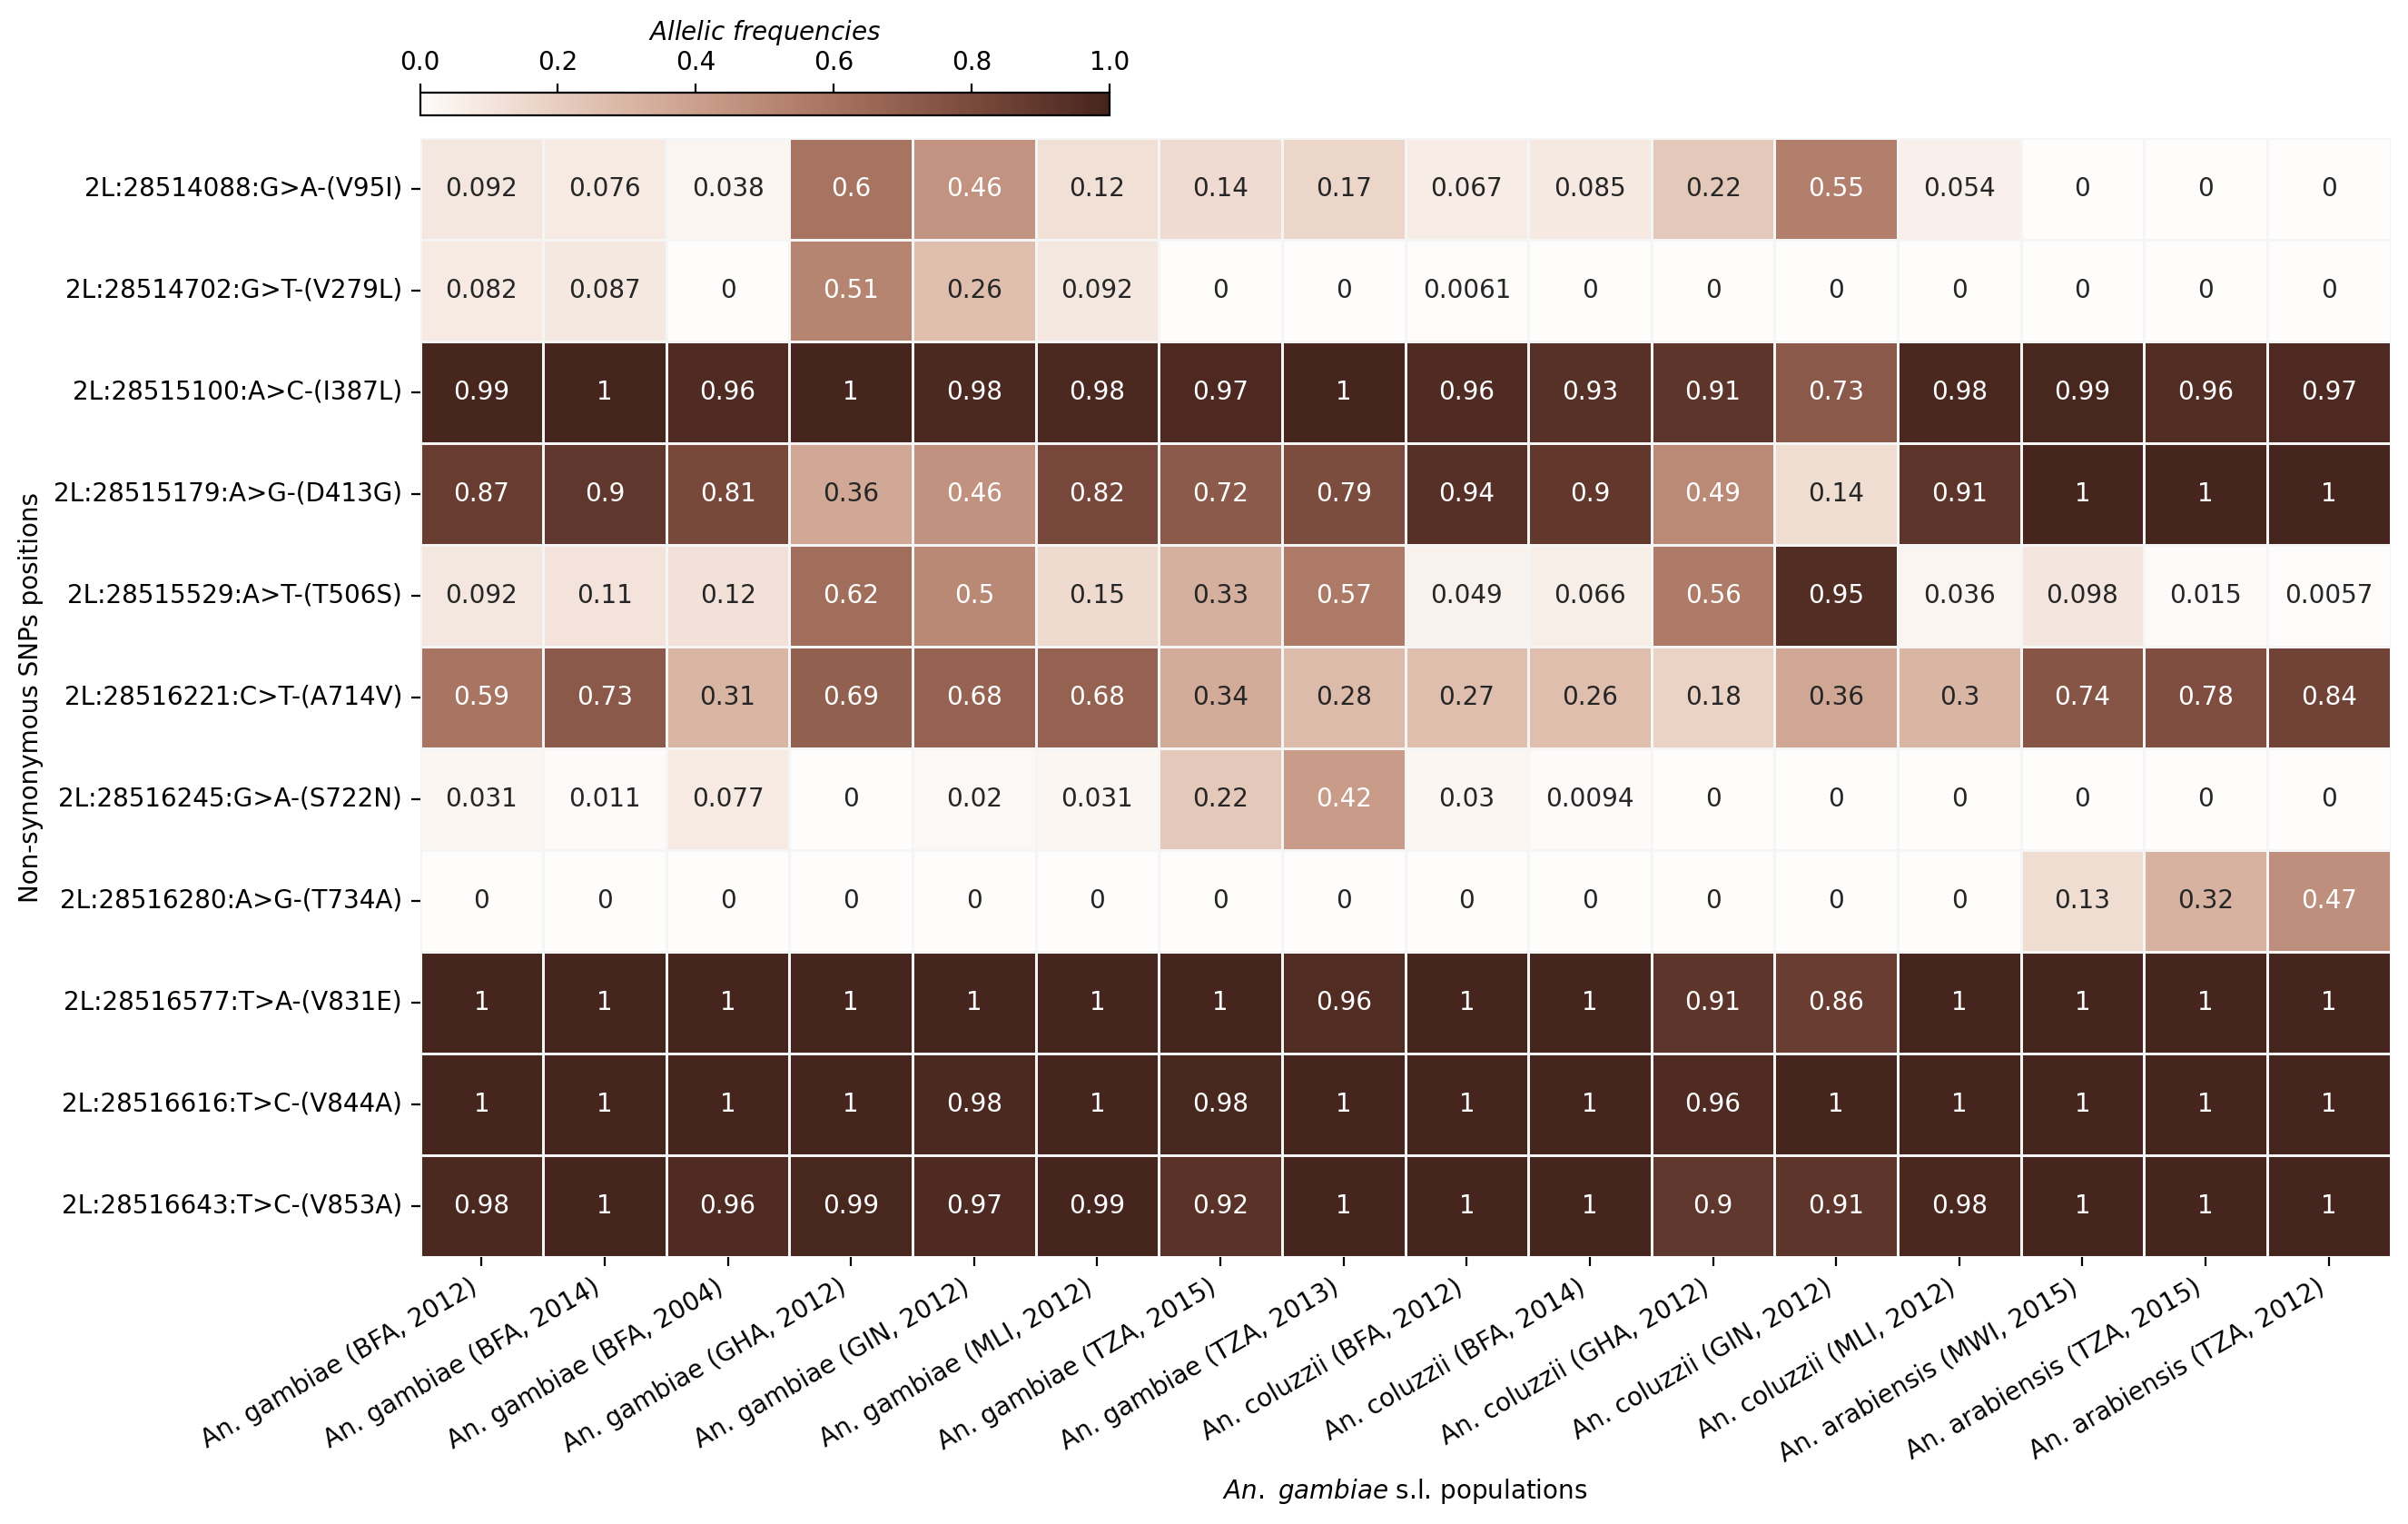

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/analyse_Ki/savefig/freq_AGAP006220.png'

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=(14, 8))
etl_df = etl.fromdataframe(select_freq1)
col_list = [name for name in select_freq1.columns if name.startswith('frq_')]
col_list.sort(key=lambda x: x.split('_')[2], reverse=True)
labs = ['%s:%s:%s>%s-(%s)' % (rec.contig,rec.position, rec.ref_allele, rec.alt_allele, rec.aa_change) for rec in etl_df.records()]

# plot
ax=sns.heatmap(select_freq1[col_list], vmin=0, vmax=1, cmap=color_2, yticklabels=labs, linewidths=0.5,
               xticklabels=[labels[key.split('frq_')[1]] for key in col_list], linecolor="whitesmoke",annot=True, cbar=False)
#ax.set_title("Alternative alleles frequencies per population ")
plt.xticks(rotation=30, ha='right')

cax = inset_axes(ax, width="35%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.02, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax, orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$Allelic$ $frequencies$')

ax.set(xlabel="$An.$ $gambiae$ s.l. populations", ylabel = 'Non-synonymous SNPs positions')

plt.show()

fig.savefig(fname='drive/MyDrive/analyse_Ki/savefig/freq_AGAP006220.png',dpi=300, bbox_inches='tight')

# AGAP006221

In [ ]:
select_freq2 = freq_AGAP006221_df.query("max_af > 0.75")
select_freq2.shape

(14, 34)

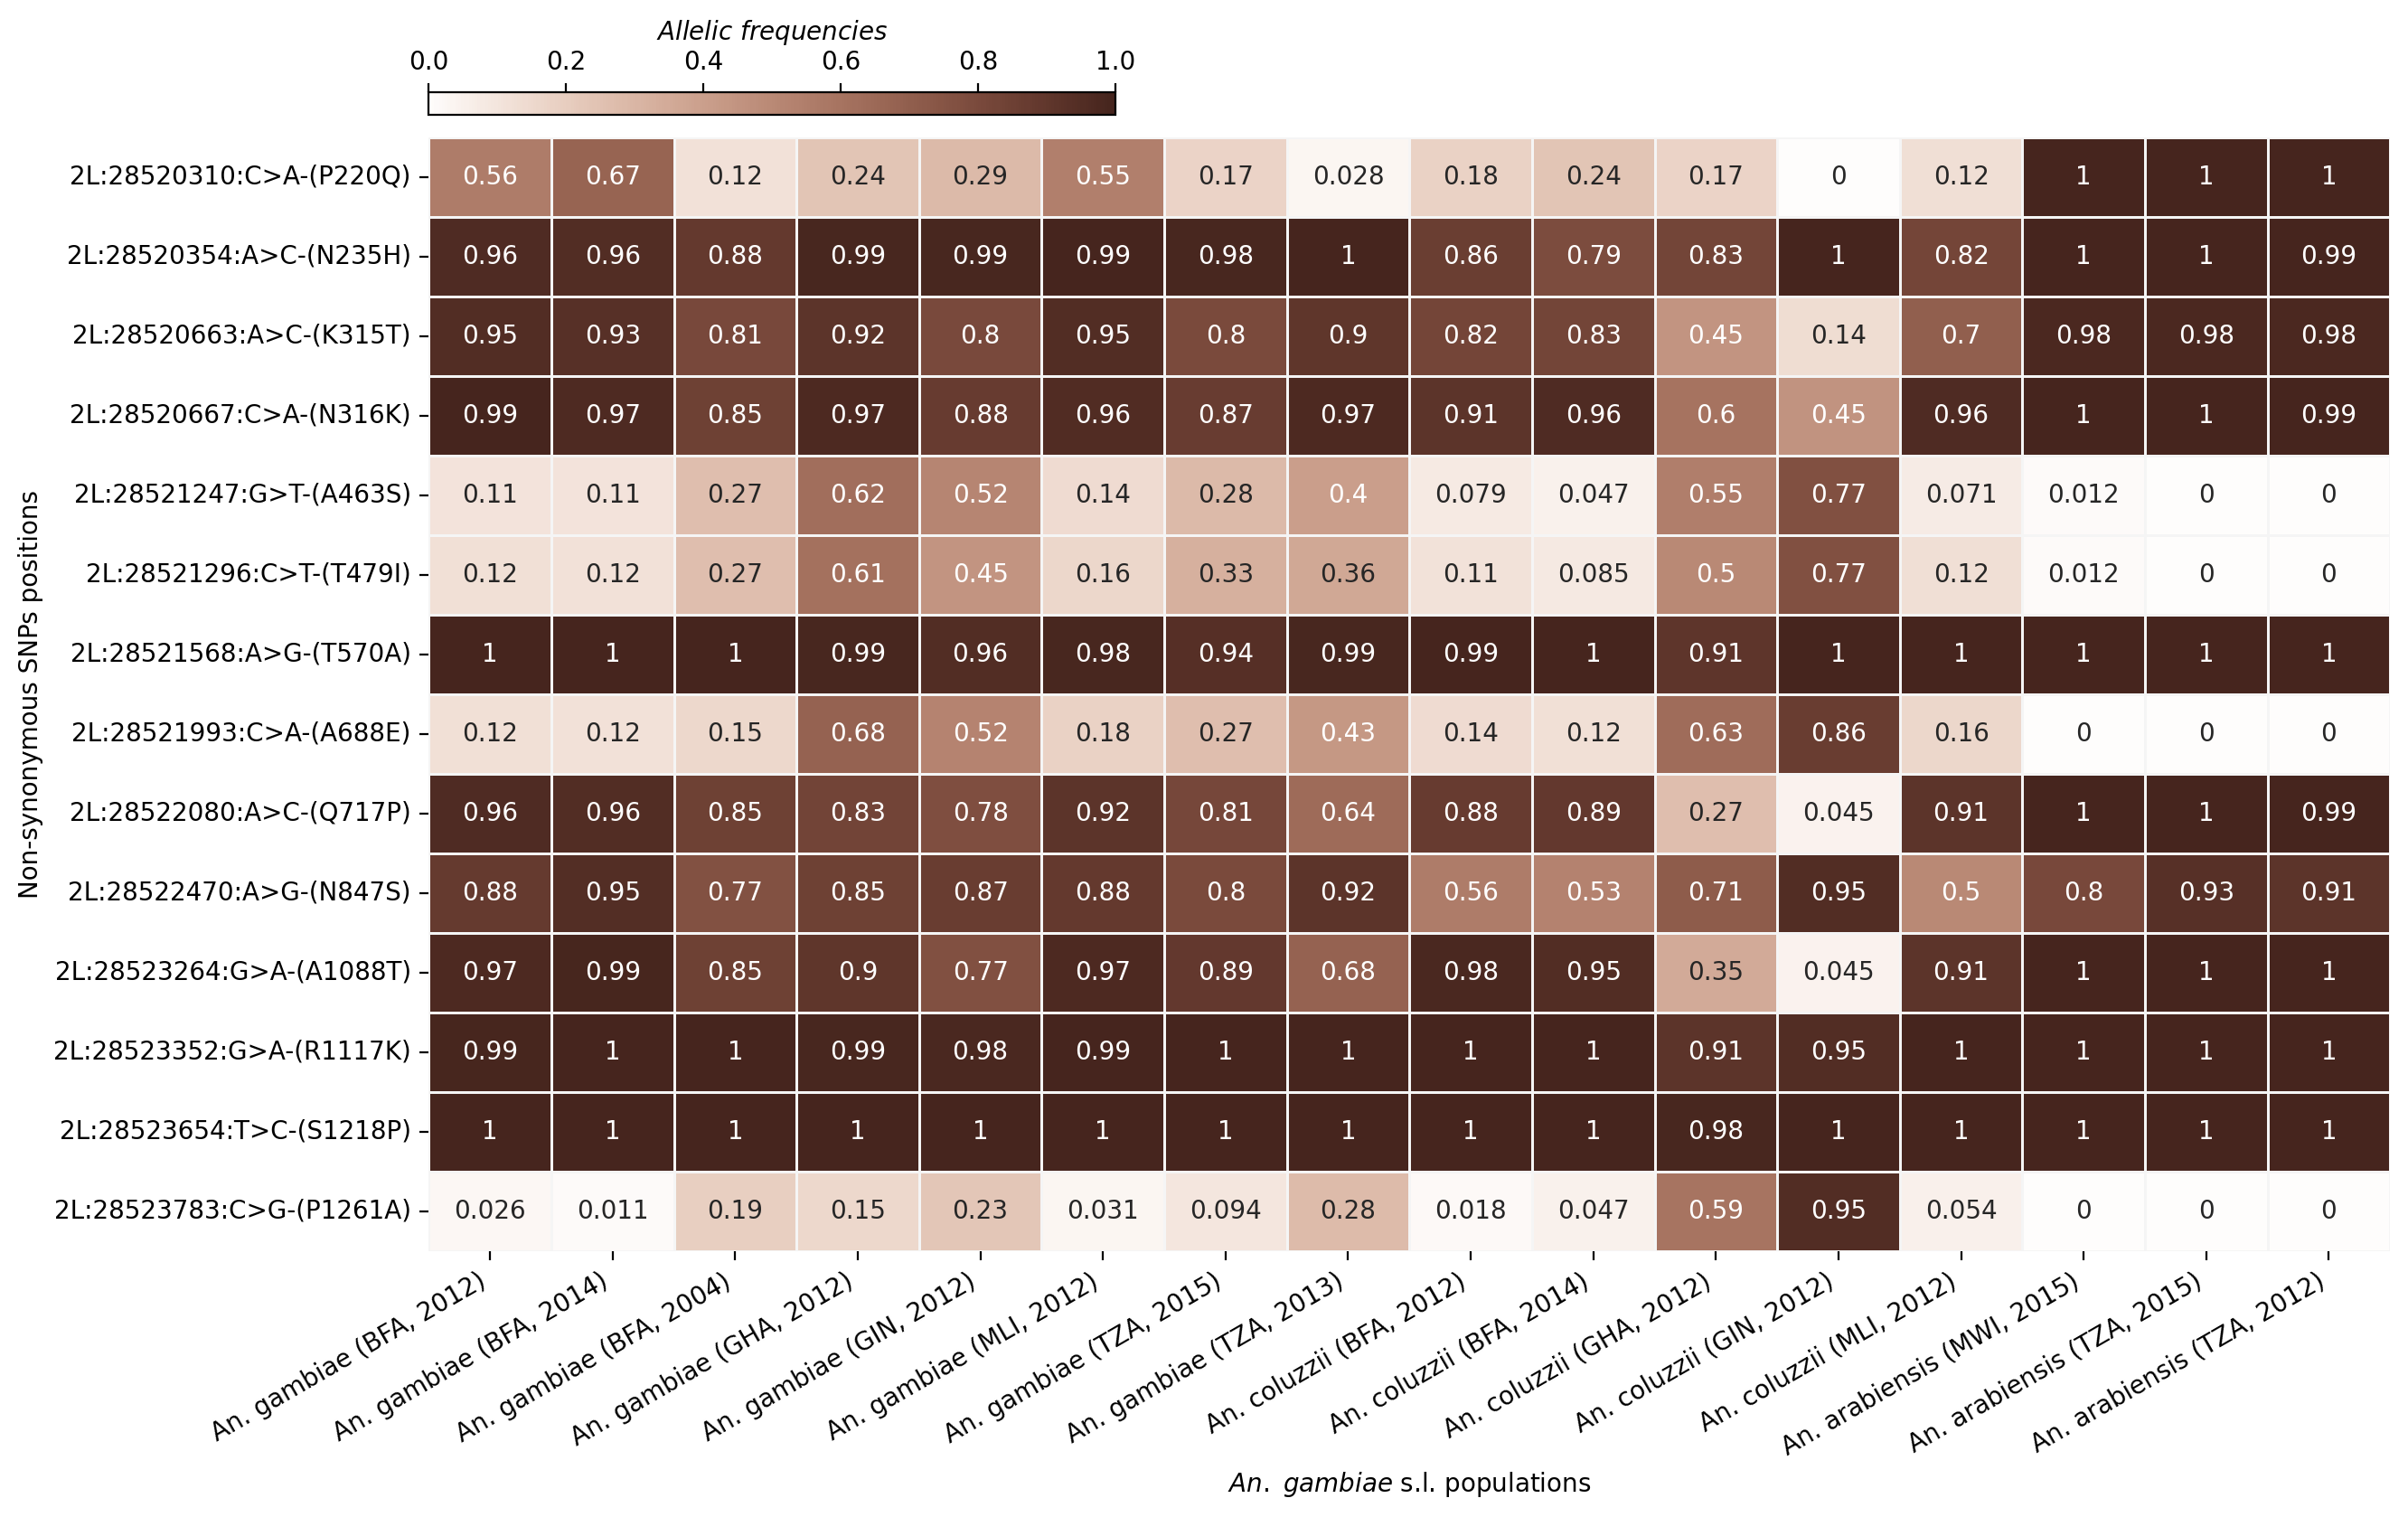

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/analyse_Ki/savefig/freq_AGAP006221.png'

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=(14, 8))
etl_df = etl.fromdataframe(select_freq2)
col_list = [name for name in select_freq2.columns if name.startswith('frq_')]
col_list.sort(key=lambda x: x.split('_')[2], reverse=True)
labs = ['%s:%s:%s>%s-(%s)' % (rec.contig,rec.position, rec.ref_allele, rec.alt_allele, rec.aa_change) for rec in etl_df.records()]

# plot
ax=sns.heatmap(select_freq2[col_list], vmin=0, vmax=1, cmap=color_2, yticklabels=labs, linewidths=0.5,
               xticklabels=[labels[key.split('frq_')[1]] for key in col_list], linecolor="whitesmoke",annot=True, cbar=False)
#ax.set_title("Alternative alleles frequencies per population ")
plt.xticks(rotation=30, ha='right')

cax = inset_axes(ax, width="35%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.02, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax, orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$Allelic$ $frequencies$')

ax.set(xlabel="$An.$ $gambiae$ s.l. populations", ylabel = 'Non-synonymous SNPs positions')

plt.show()

fig.savefig(fname='drive/MyDrive/analyse_Ki/savefig/freq_AGAP006221.png',dpi=300, bbox_inches='tight')

# AGAP006224

In [ ]:
select_freq3 = freq_AGAP006224_df.query("max_af > 0.75")
select_freq3.shape

(29, 34)

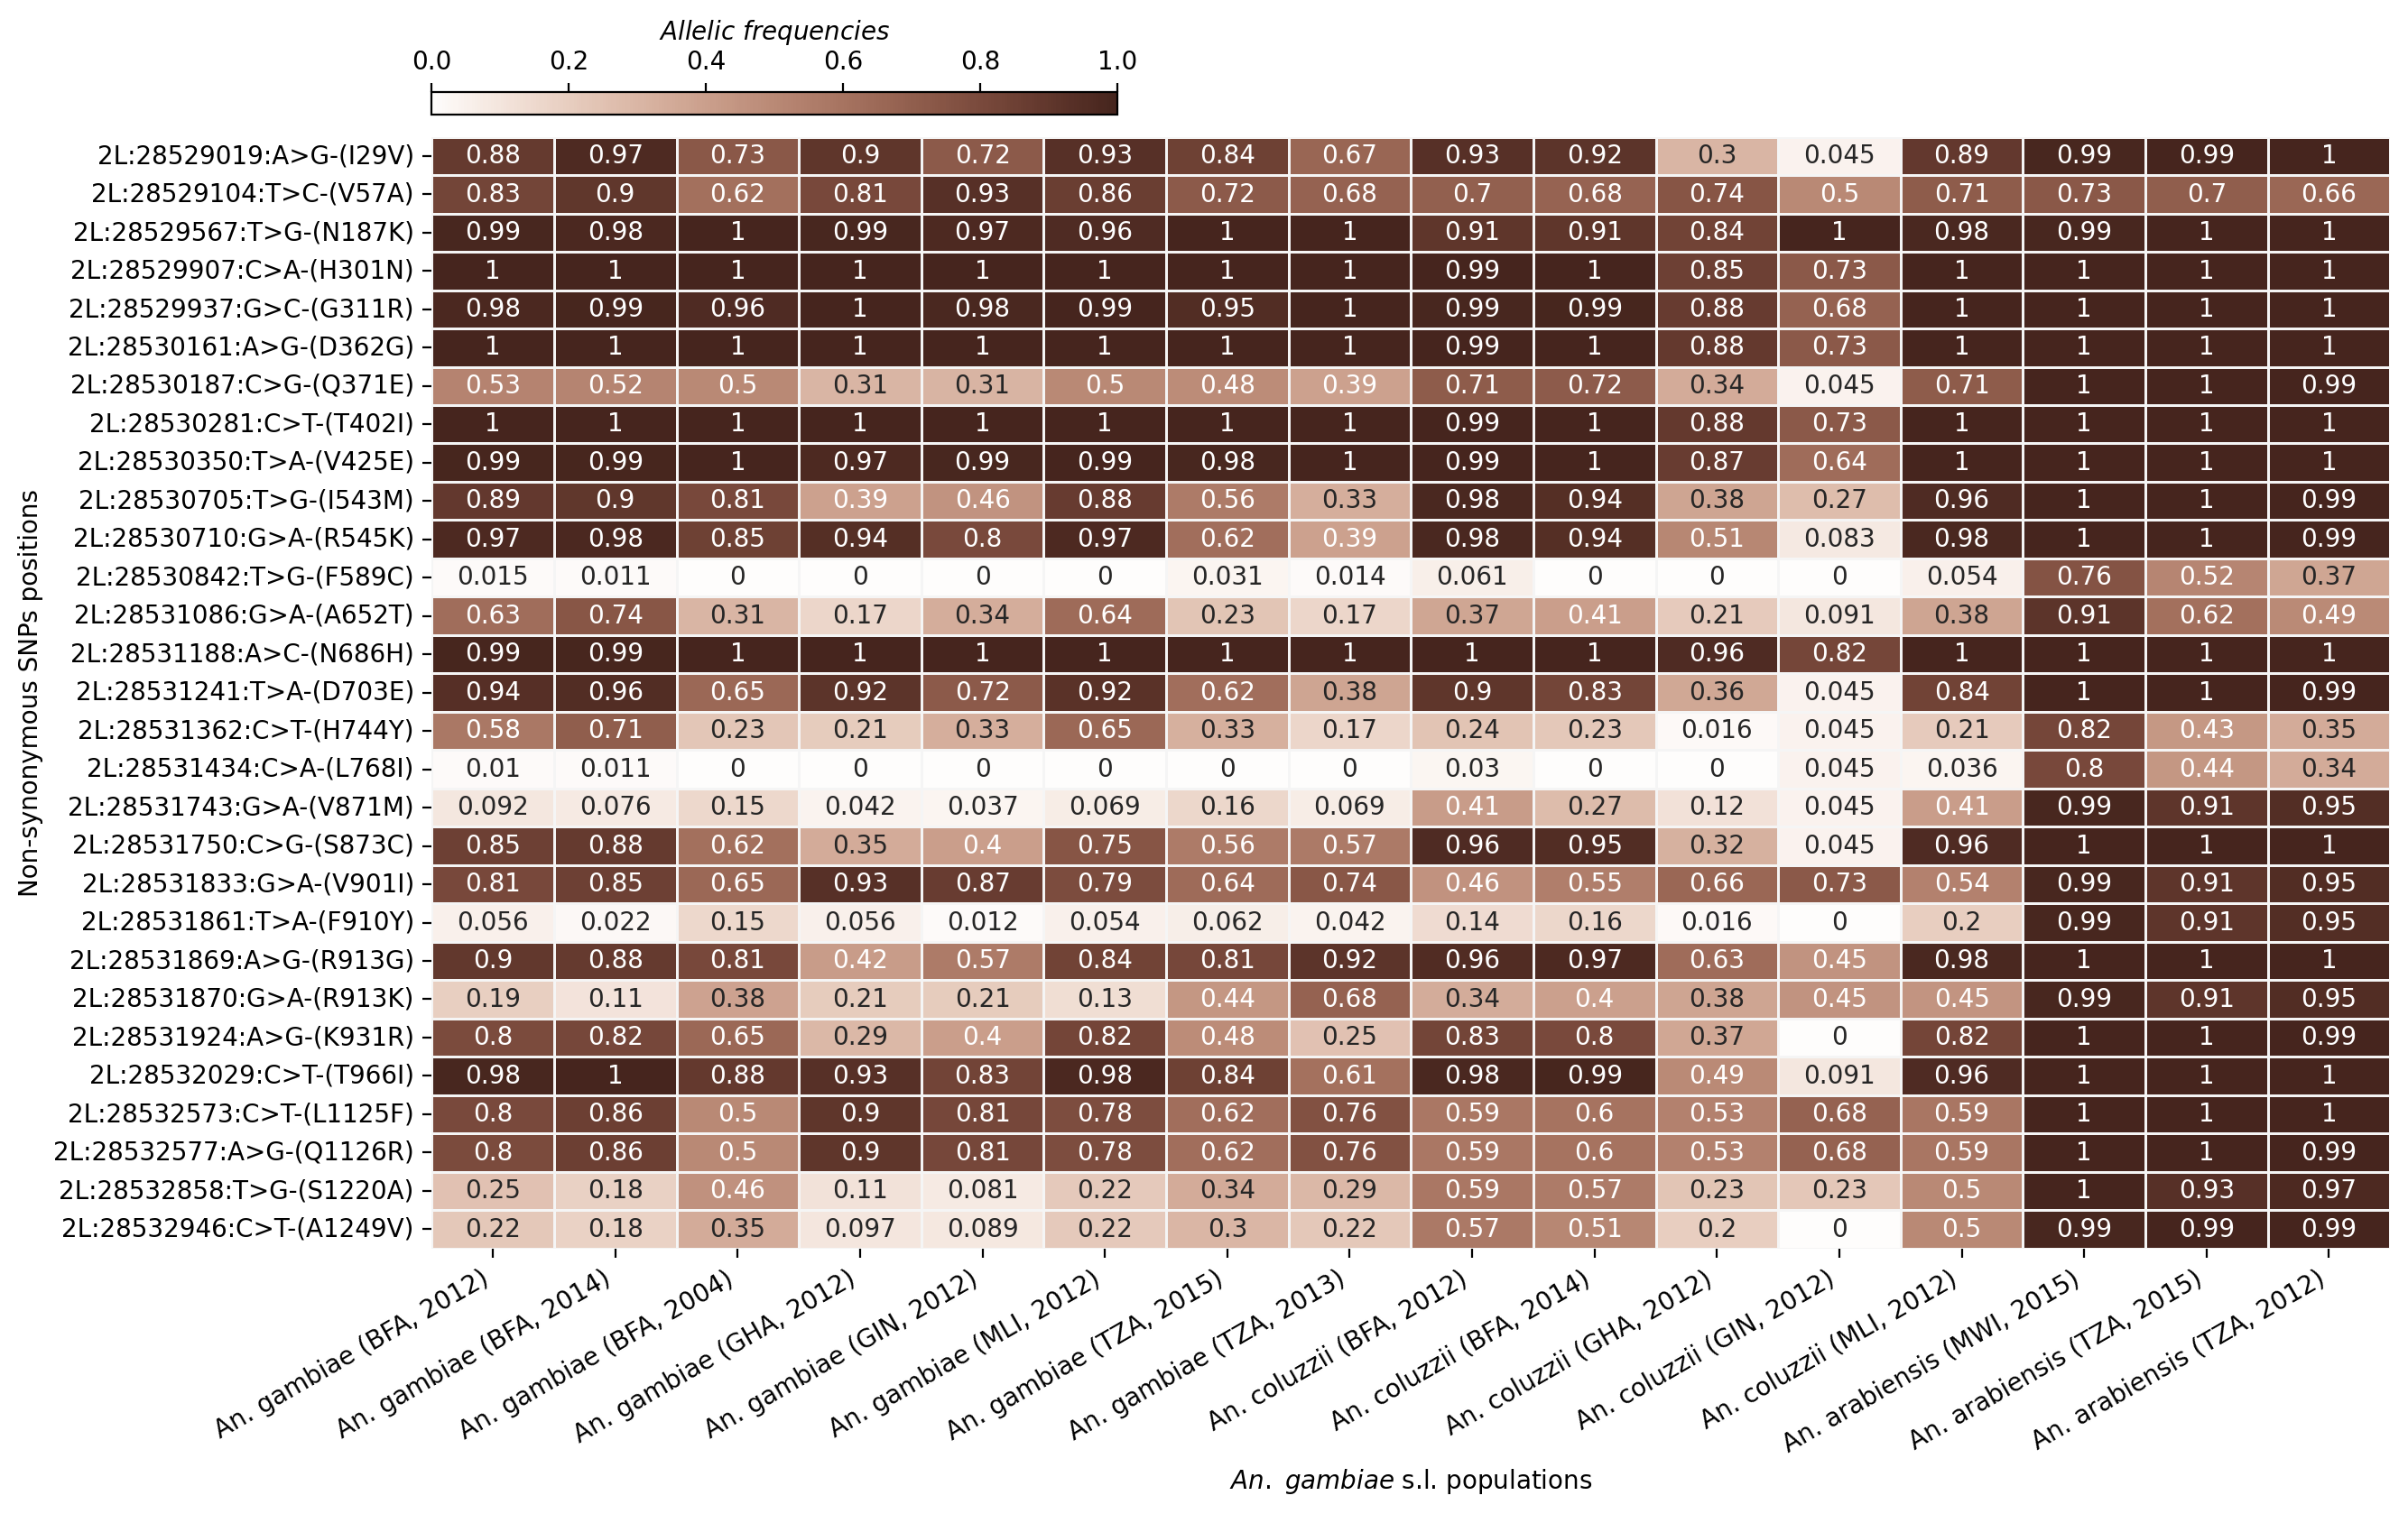

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/analyse_Ki/savefig/freq_AGAP006224.png'

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=(14, 8))
etl_df = etl.fromdataframe(select_freq3)
col_list = [name for name in select_freq3.columns if name.startswith('frq_')]
col_list.sort(key=lambda x: x.split('_')[2], reverse=True)
labs = ['%s:%s:%s>%s-(%s)' % (rec.contig,rec.position, rec.ref_allele, rec.alt_allele, rec.aa_change) for rec in etl_df.records()]

# plot
ax=sns.heatmap(select_freq3[col_list], vmin=0, vmax=1, cmap=color_2, yticklabels=labs, linewidths=0.5,
               xticklabels=[labels[key.split('frq_')[1]] for key in col_list], linecolor="whitesmoke",annot=True, cbar=False)
#ax.set_title("Alternative alleles frequencies  gene")
plt.xticks(rotation=30, ha='right')

cax = inset_axes(ax, width="35%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.02, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax, orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$Allelic$ $frequencies$')

ax.set(xlabel="$An.$ $gambiae$ s.l. populations", ylabel = 'Non-synonymous SNPs positions')

plt.show()

fig.savefig(fname='drive/MyDrive/analyse_Ki/savefig/freq_AGAP006224.png',dpi=300, bbox_inches='tight')

# AGAP006225

In [ ]:
select_freq4 = freq_AGAP006225_df.query("max_af > 0.5")
select_freq4.shape

(10, 34)

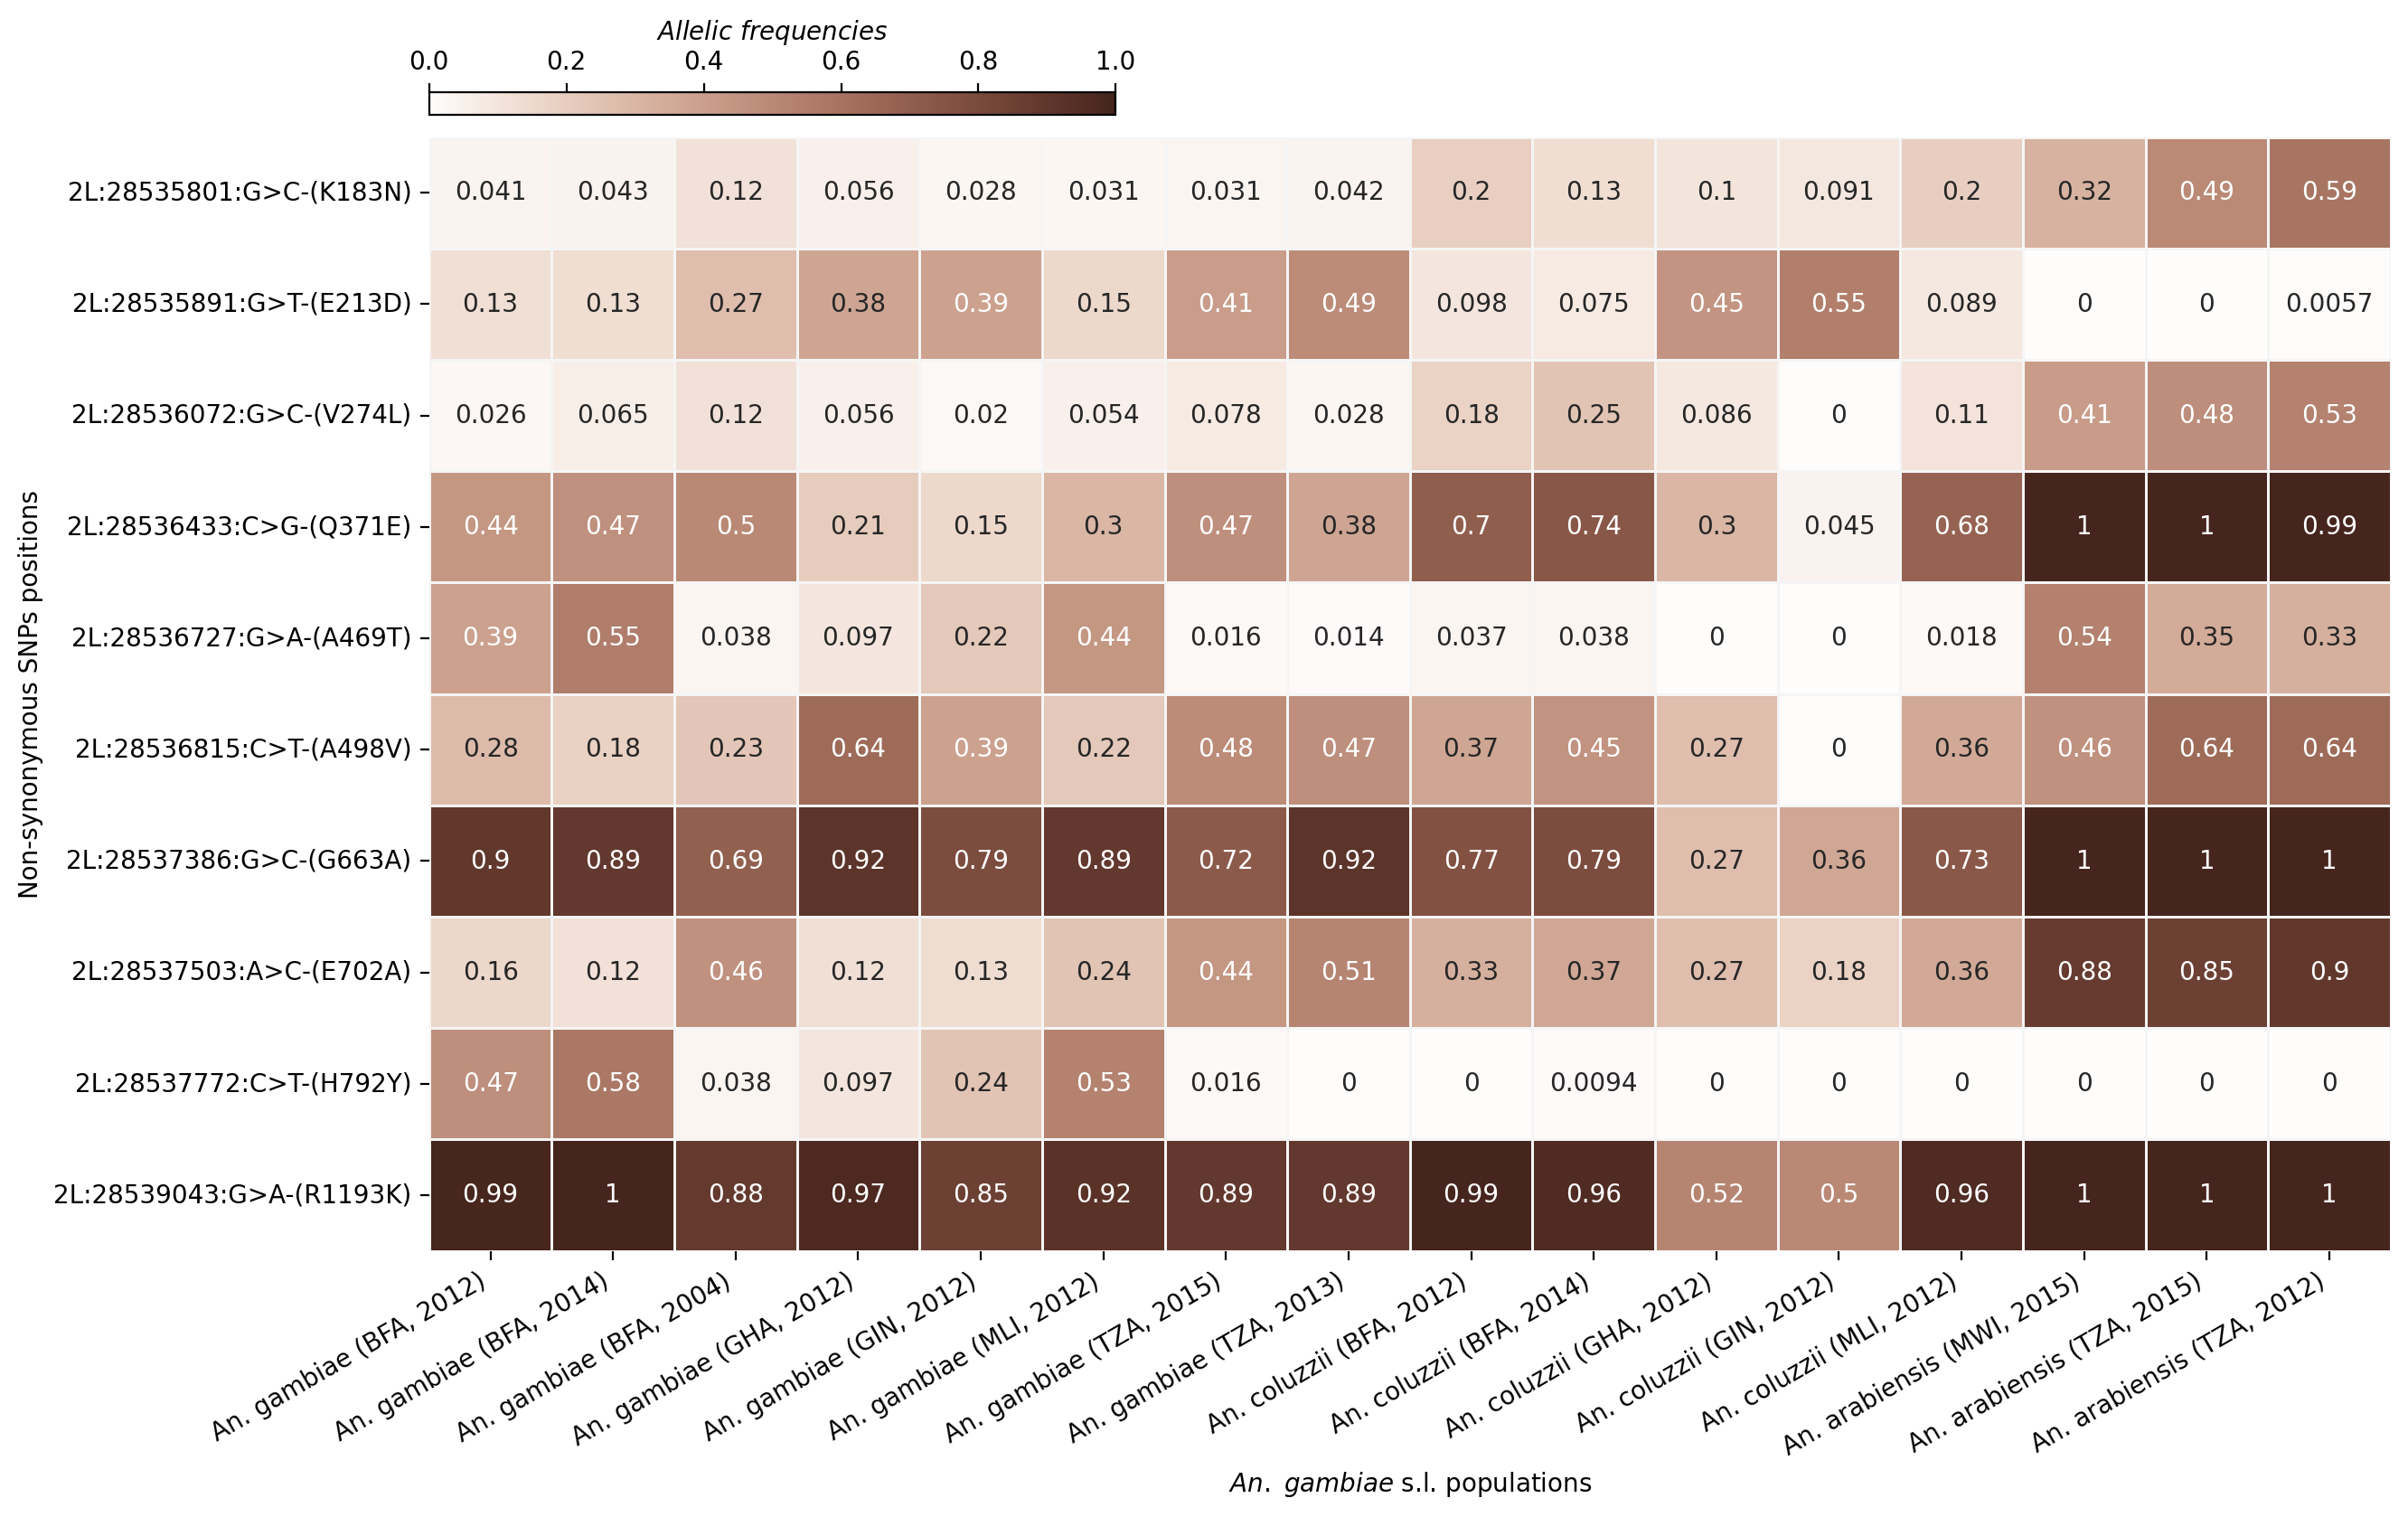

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/analyse_Ki/savefig/freq_AGAP006225.png'

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=(14, 8))
etl_df = etl.fromdataframe(select_freq4)
col_list = [name for name in select_freq4.columns if name.startswith('frq_')]
col_list.sort(key=lambda x: x.split('_')[2], reverse=True)
labs = ['%s:%s:%s>%s-(%s)' % (rec.contig,rec.position, rec.ref_allele, rec.alt_allele, rec.aa_change) for rec in etl_df.records()]

# plot
ax=sns.heatmap(select_freq4[col_list], vmin=0, vmax=1, cmap=color_2, yticklabels=labs, linewidths=0.5,
               xticklabels=[labels[key.split('frq_')[1]] for key in col_list], linecolor="whitesmoke",annot=True, cbar=False)
#ax.set_title("Alternative alleles frequencies  gene")
plt.xticks(rotation=30, ha='right')

cax = inset_axes(ax, width="35%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.02, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax, orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$Allelic$ $frequencies$')

ax.set(xlabel="$An.$ $gambiae$ s.l. populations", ylabel = 'Non-synonymous SNPs positions')

plt.show()

fig.savefig(fname='drive/MyDrive/analyse_Ki/savefig/freq_AGAP006225.png',dpi=300, bbox_inches='tight')

# AGAP006226

In [ ]:
select_freq5 = freq_AGAP006226_df.query("max_af > 0.75")
select_freq5.shape

(13, 34)

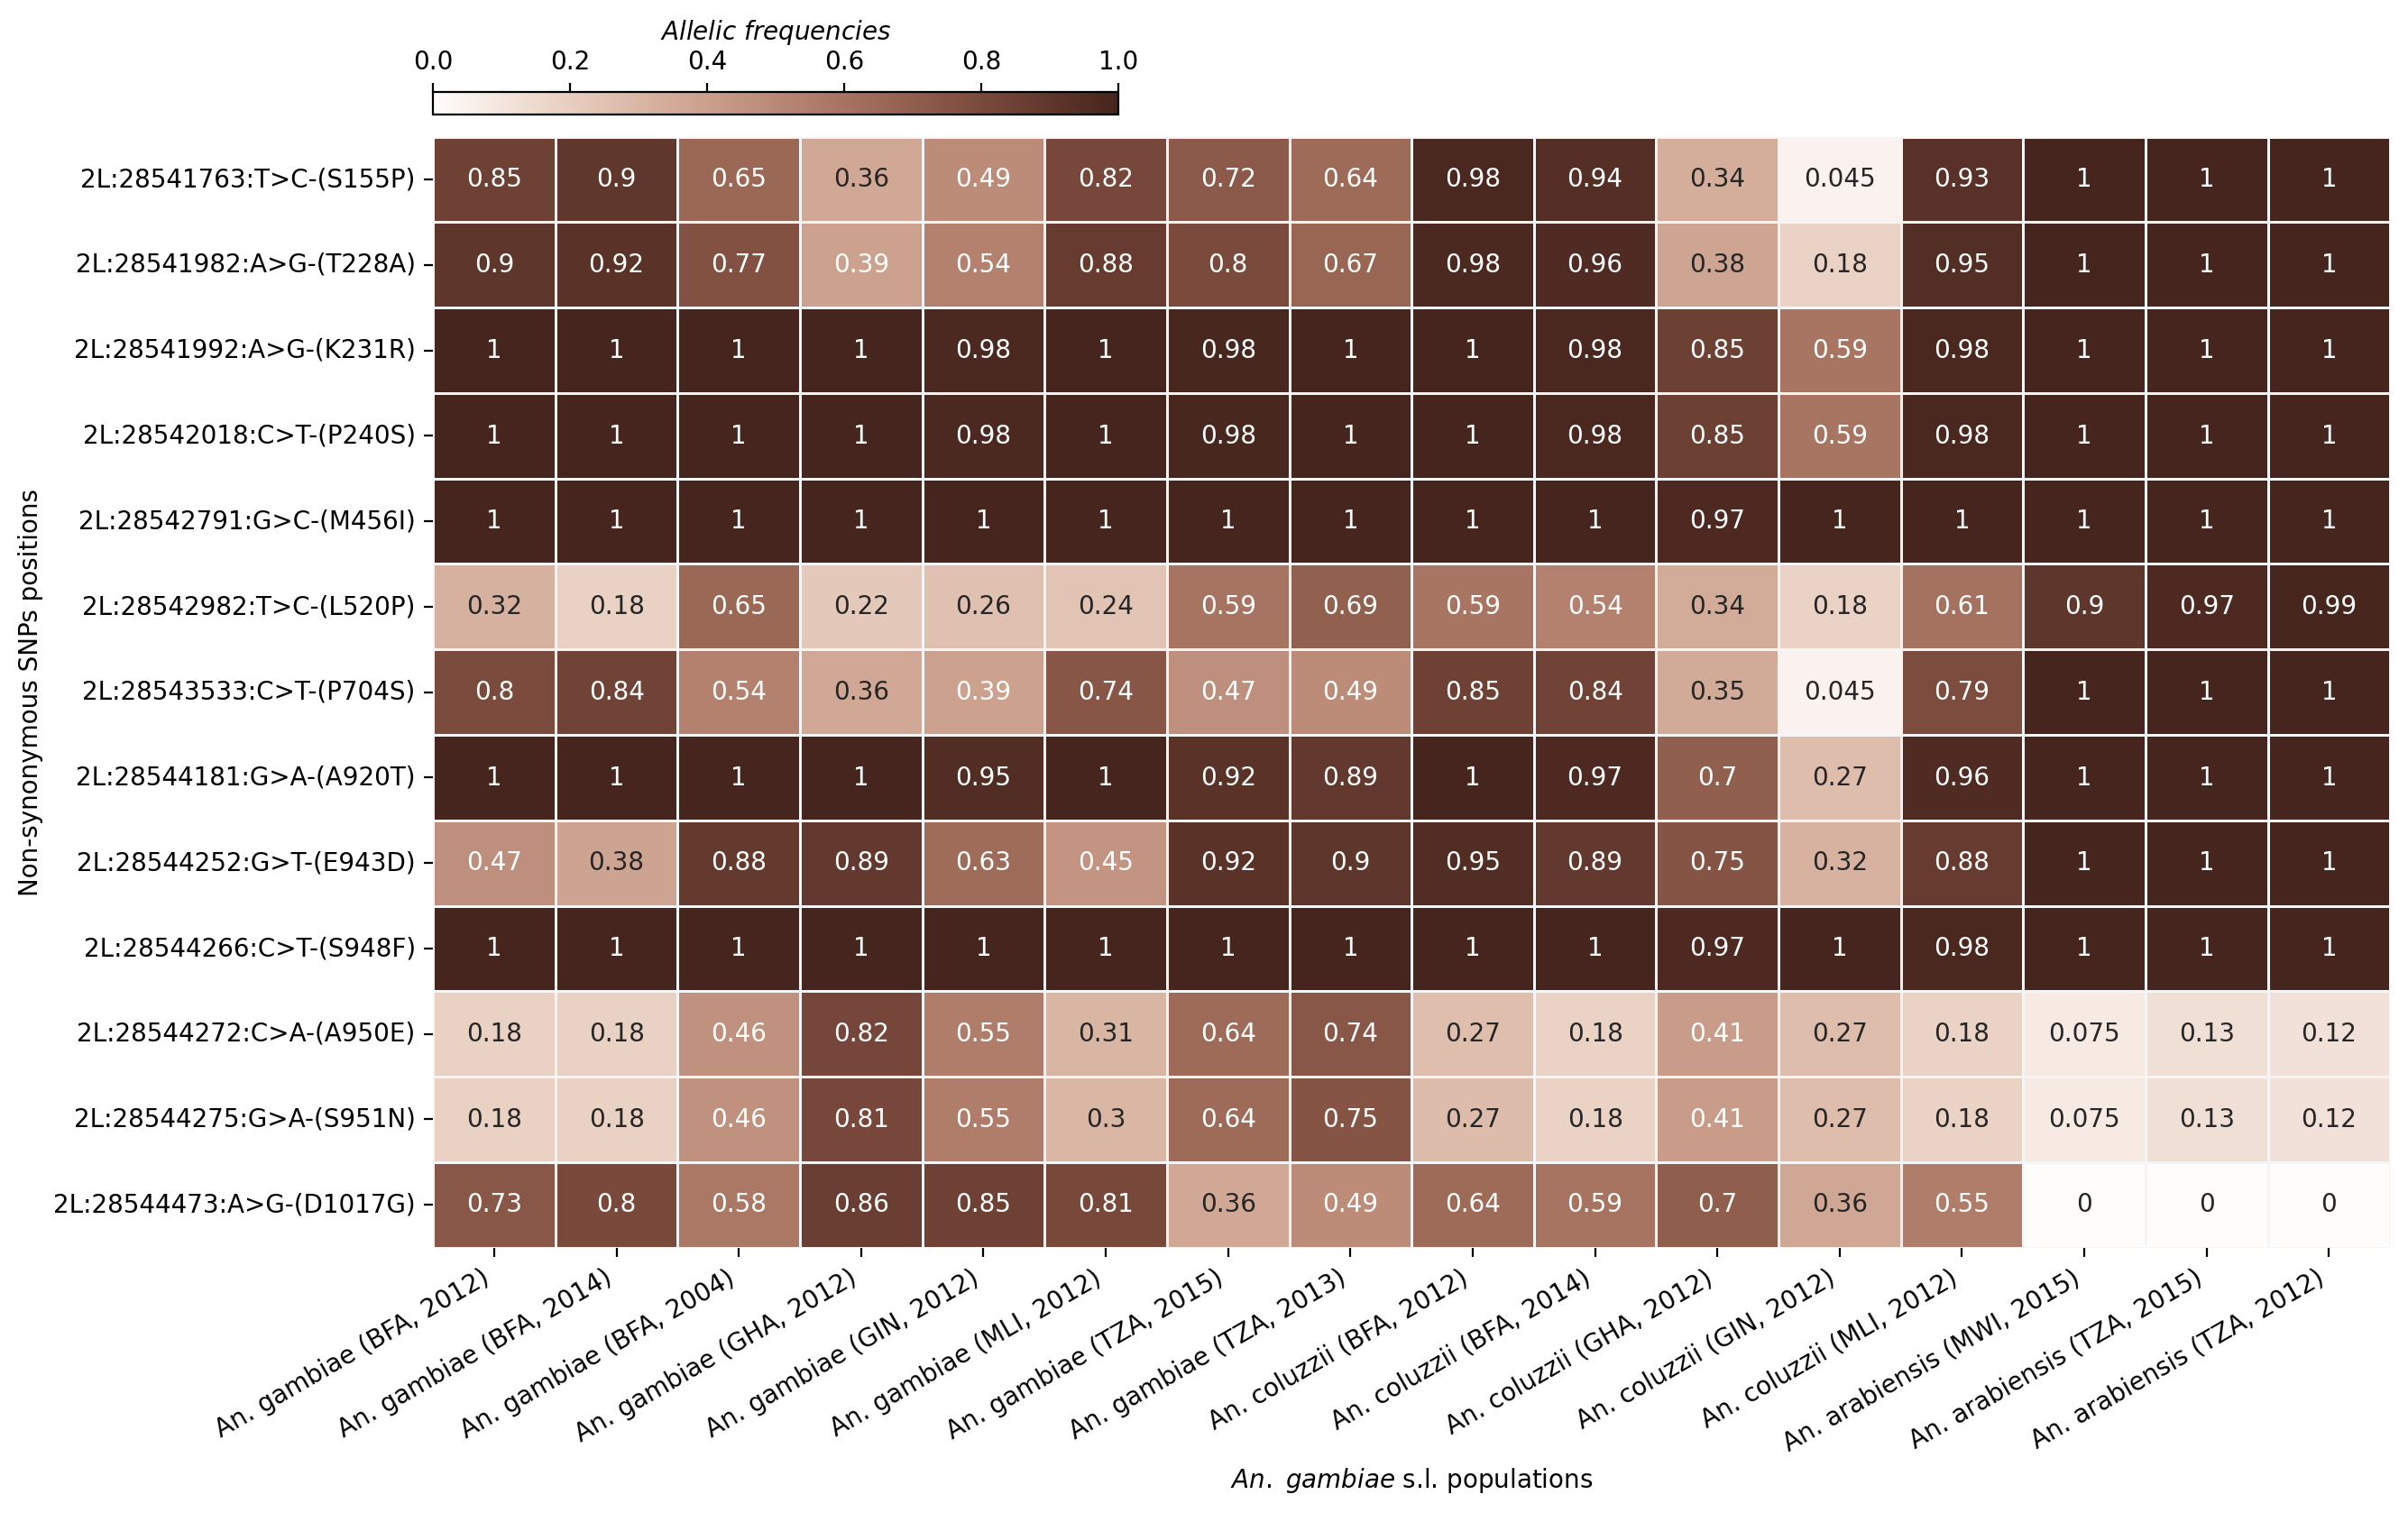

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/analyse_Ki/savefig/freq_AGAP006226.png'

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=(14, 8))
etl_df = etl.fromdataframe(select_freq5)
col_list = [name for name in select_freq5.columns if name.startswith('frq_')]
col_list.sort(key=lambda x: x.split('_')[2], reverse=True)
labs = ['%s:%s:%s>%s-(%s)' % (rec.contig,rec.position, rec.ref_allele, rec.alt_allele, rec.aa_change) for rec in etl_df.records()]

# plot
ax=sns.heatmap(select_freq5[col_list], vmin=0, vmax=1, cmap=color_2, yticklabels=labs, linewidths=0.5,
               xticklabels=[labels[key.split('frq_')[1]] for key in col_list], linecolor="whitesmoke",annot=True, cbar=False)
#ax.set_title("Alternative alleles frequencies  gene")
plt.xticks(rotation=30, ha='right')

cax = inset_axes(ax, width="35%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.02, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax, orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$Allelic$ $frequencies$')

ax.set(xlabel="$An.$ $gambiae$ s.l. populations", ylabel = 'Non-synonymous SNPs positions')

plt.show()

fig.savefig(fname='drive/MyDrive/analyse_Ki/savefig/freq_AGAP006226.png',dpi=300, bbox_inches='tight')

## CNV freq

In [ ]:
## CNV freq
ald_list = ['AGAP006220', 'AGAP006221', 'AGAP006224', 'AGAP006225', 'AGAP006226']
aldehyde_cnv = ag3.gene_cnv_frequencies(
    region=ald_list,
    cohorts=cohorts,
    sample_sets=sets,
    )

##
aldehyde_cnv_frq = aldehyde_cnv.copy().reset_index()
#aldehyde_cnv_frq

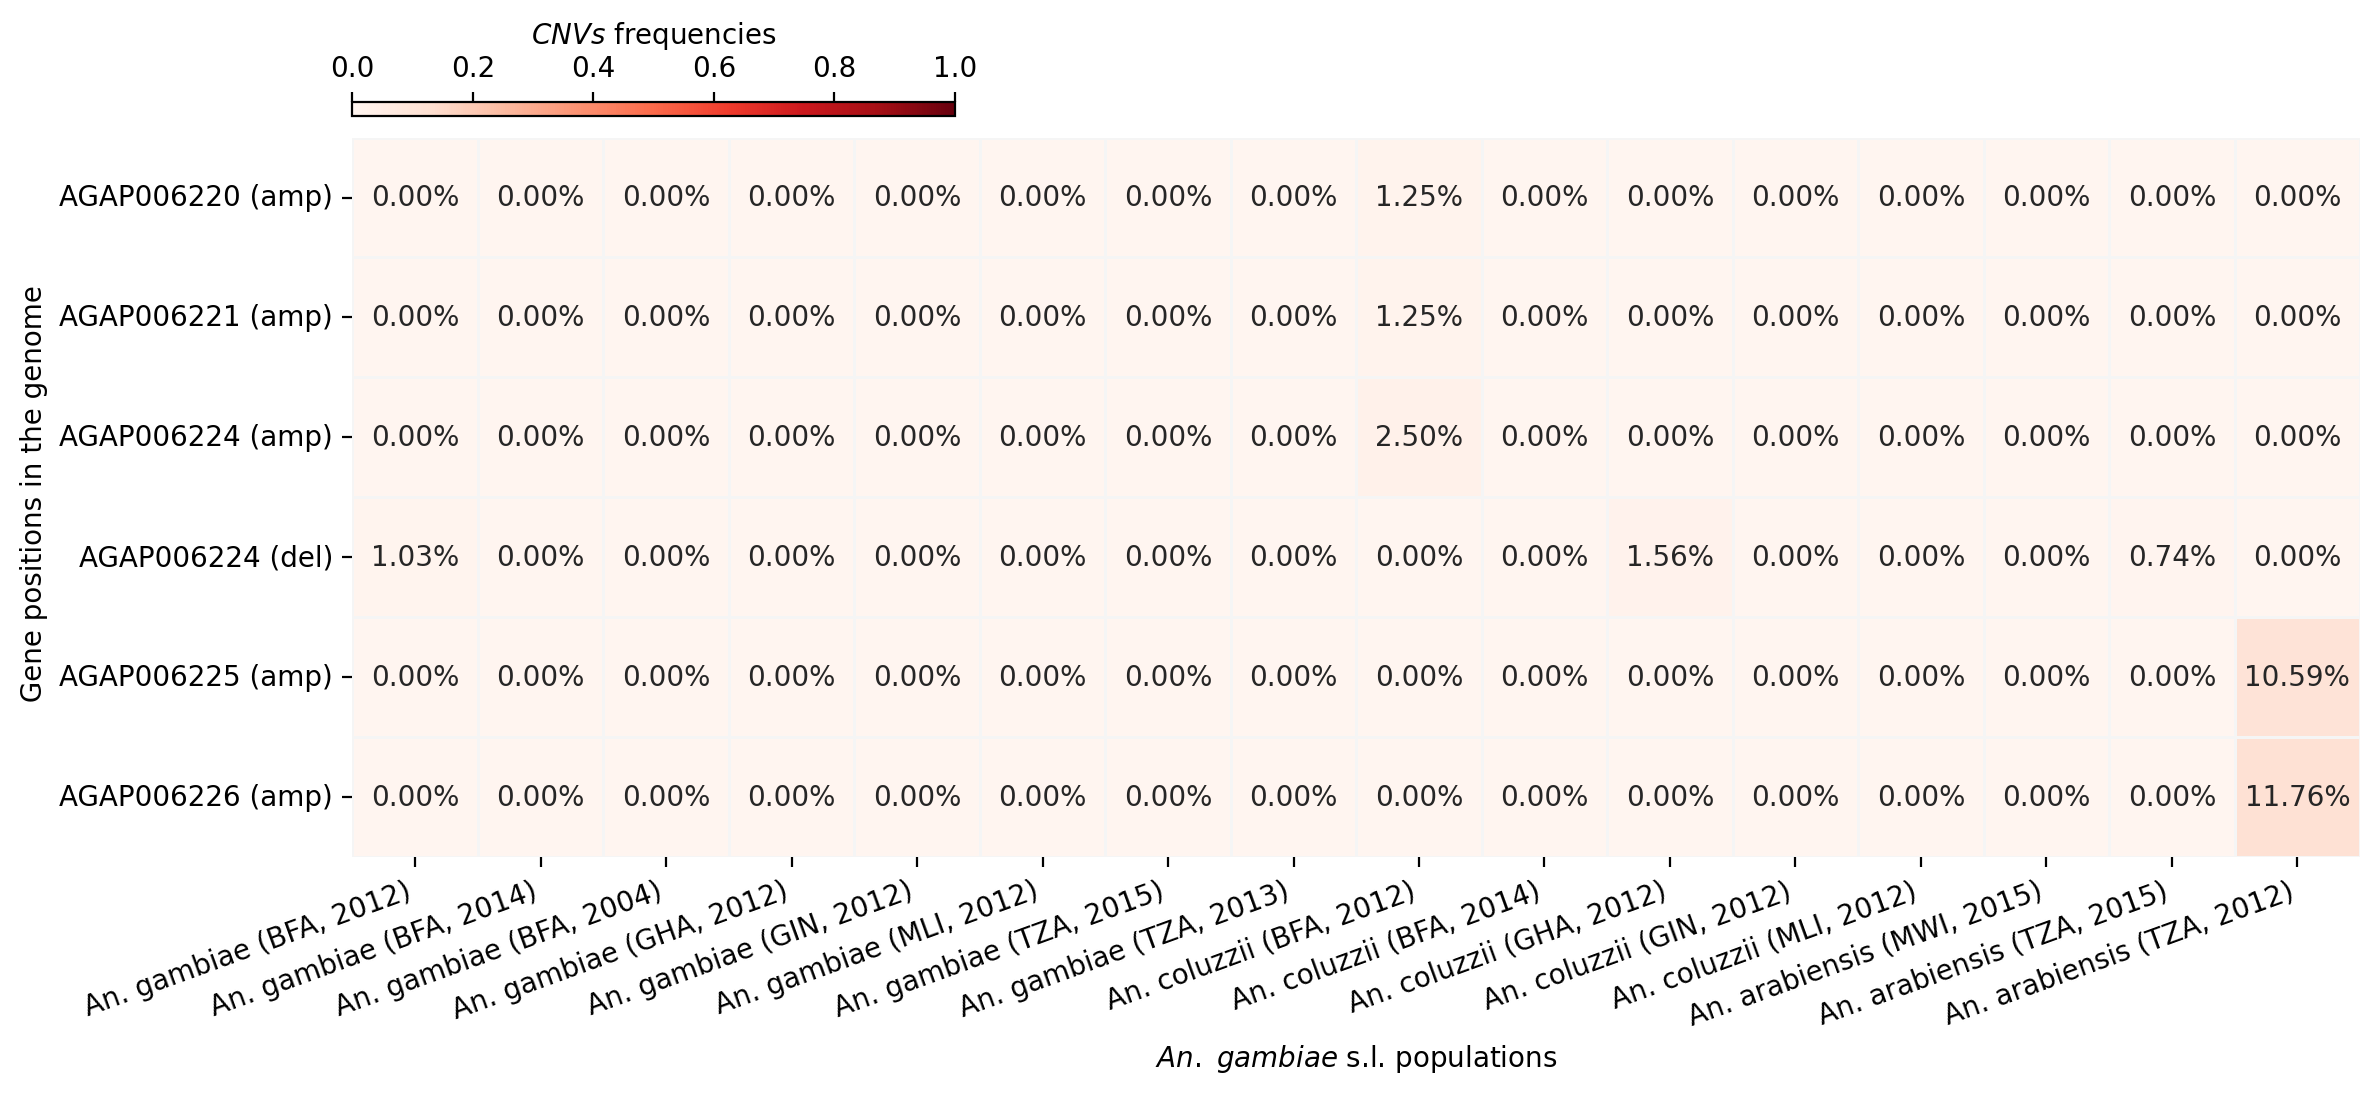

In [ ]:
# plot allele freqs per pop
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=(12,5))
#sns.set(font_scale = 1)
#Selecting data
select_coe = aldehyde_cnv_frq#.query('max_af > 0.05')
ptl_df_coe = etl.fromdataframe(select_coe)

#set labels
labs = ['%s (%s)' % (rec.gene_id, rec.cnv_type) for rec in ptl_df_coe.records()]
color_2 = sns.color_palette("Reds", as_cmap=True)

# plot
ax=sns.heatmap(select_coe[col_list], vmin=0, vmax=1, fmt='.2%', cmap=color_2, yticklabels=labs,
               xticklabels=[labels[key.split('frq_')[1]] for key in col_list],
               linewidths=0.5, linecolor="whitesmoke",annot=True, cbar=False)
plt.xticks(rotation=20, ha='right')

ax.set(xlabel="$An.$ $gambiae$ s.l. populations", ylabel = ' Gene positions in the genome')

cax = inset_axes(ax,width="30%", height="2%", loc='lower left', bbox_to_anchor=(0, 1.03, 1, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
mpl.colorbar.ColorbarBase(cax,orientation='horizontal', ticklocation='top',cmap=color_2,
                         label='$CNVs$ frequencies')

fig.tight_layout()

fig.savefig(fname='drive/MyDrive/analyse_Ki/savefig/cnv_freq.png',dpi=300, bbox_inches='tight')

In [ ]:
aldehyde_cnv_frq

gene_id         gene_name cnv_type gene_strand  \
0  AGAP006220               NaN      amp           +   
1  AGAP006221               NaN      amp           +   
2  AGAP006224               NaN      amp           +   
3  AGAP006224               NaN      del           +   
4  AGAP006225               NaN      amp           +   
5  AGAP006226  Aldehyde_oxidase      amp           +   

                                    gene_description contig     start  \
0  aldehyde oxidase [Source:VB Community Annotation]     2L  28512602   
1  aldehyde oxidase [Source:VB Community Annotation]     2L  28518055   
2  aldehyde oxidase [Source:VB Community Annotation]     2L  28528758   
3  aldehyde oxidase [Source:VB Community Annotation]     2L  28528758   
4  aldehyde oxidase [Source:VB Community Annotation]     2L  28534732   
5                                                NaN     2L  28540651   

        end  frq_BFA_gambiae_2012  frq_BFA_coluzzii_2012  \
0  28517680              0.000000                 0.0125   
1  28523900              0.000000                 0.0125   
2  28533199              0.000000                 0.0250   
3  28533199              0.010309                 0.0000   
4  28539416              0.000000                 0.0000   
5  28545294              0.000000                 0.0000   

   frq_BFA_coluzzii_2014  frq_BFA_gambiae_2014  frq_BFA_gambiae_2004  \
0                    0.0                   0.0                   0.0   
1                    0.0                   0.0                   0.0   
2                    0.0                   0.0                   0.0   
3                    0.0                   0.0                   0.0   
4                    0.0                   0.0                   0.0   
5                    0.0                   0.0                   0.0   

   frq_GHA_coluzzii_2012  frq_GHA_gambiae_2012  frq_GIN_gambiae_2012  \
0               0.000000                   0.0                   0.0   
1               0.000000                   0.0                   0.0   
2               0.000000                   0.0                   0.0   
3               0.015625                   0.0                   0.0   
4               0.000000                   0.0                   0.0   
5               0.000000                   0.0                   0.0   

   frq_GIN_coluzzii_2012  frq_MLI_gambiae_2012  frq_MLI_coluzzii_2012  \
0                    0.0                   0.0                    0.0   
1                    0.0                   0.0                    0.0   
2                    0.0                   0.0                    0.0   
3                    0.0                   0.0                    0.0   
4                    0.0                   0.0                    0.0   
5                    0.0                   0.0                    0.0   

   frq_MWI_arabiensis_2015  frq_TZA_arabiensis_2015  frq_TZA_gambiae_2015  \
0                      0.0                 0.000000                   0.0   
1                      0.0                 0.000000                   0.0   
2                      0.0                 0.000000                   0.0   
3                      0.0                 0.007353                   0.0   
4                      0.0                 0.000000                   0.0   
5                      0.0                 0.000000                   0.0   

   frq_TZA_arabiensis_2012  frq_TZA_gambiae_2013    max_af  windows  \
0                 0.000000                   0.0  0.012500       17   
1                 0.000000                   0.0  0.012500       20   
2                 0.000000                   0.0  0.025000       16   
3                 0.000000                   0.0  0.015625       16   
4                 0.105882                   0.0  0.105882       17   
5                 0.117647                   0.0  0.117647       16   

                               label  
0                     AGAP006220 amp  
1                     AGAP006221 amp  
2  